# 머신러닝

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import sklearn.svm as svm
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import time
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

## 1. 데이터 탐색
(1) 시각화 포함 탐색적 자료분석을 시행하시오(EDA).

In [2]:
data_path = '/hdd/data/adp_data/diabetes_for_test.csv'
df1 = pd.read_csv(data_path)
df1

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [3]:
diabets = df1.groupby('Outcome').mean()
diabets

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Outcome,,,,,,,,
0,3.298000,109.980000,68.184000,19.664000,68.792000,30.304200,0.429734,36.934000
1,4.865672,141.257463,70.824627,22.164179,100.335821,35.142537,0.550500,37.067164


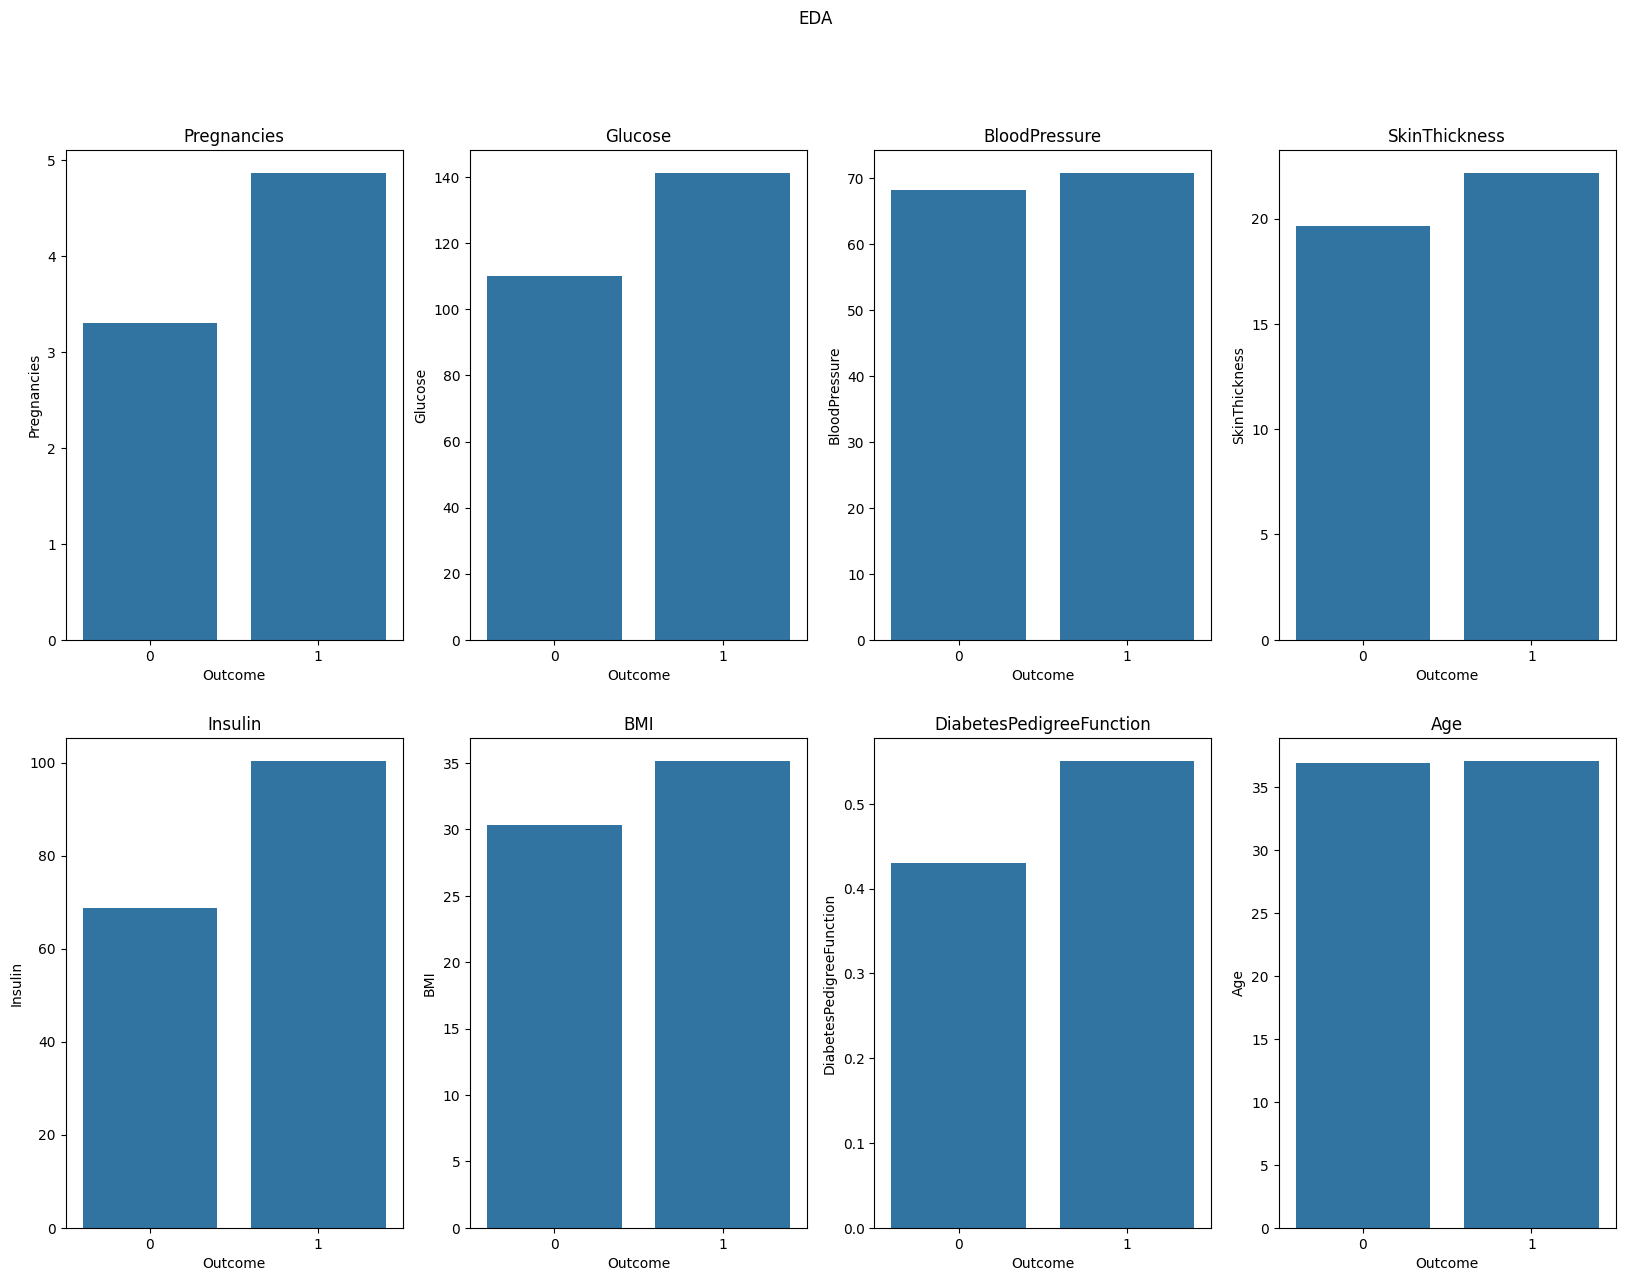

In [4]:
fig, axes = plt.subplots(2, 4, figsize = (20, 14))

for i in range(4):
    sns.barplot(x = diabets.index, y = diabets.iloc[:, i], ax = axes[0][i])
    axes[0][i].set_title(diabets.columns[i])

for i in range(4):
    sns.barplot(x = diabets.index, y = diabets.iloc[:, i+4], ax = axes[1][i])
    axes[1][i].set_title(diabets.columns[i+4])

plt.suptitle('EDA')
plt.show()

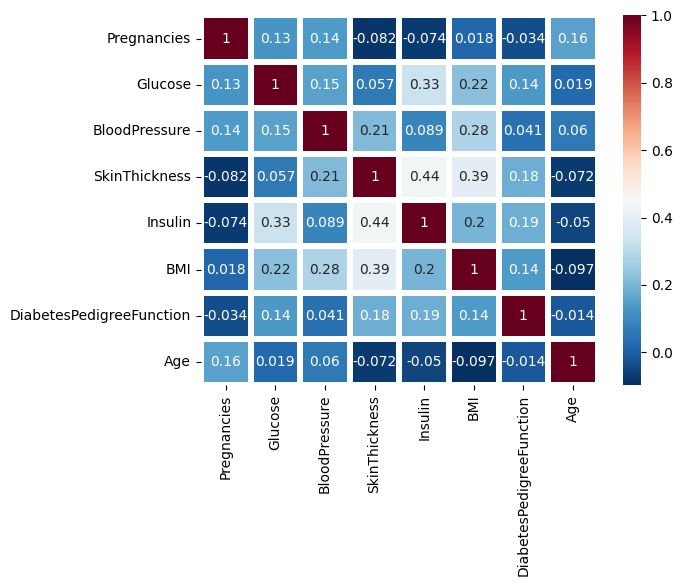

In [5]:
df_cor = df1.drop(columns = ['Outcome']).corr(method = 'pearson')
sns.heatmap(
    df_cor,
    xticklabels = df_cor.columns,
    yticklabels = df_cor.columns,
    cmap = 'RdBu_r',
    annot = True,
    linewidths = 3
)
plt.show()

(2) 이상치를 식별하고 처리하시오.

In [6]:
df1.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,36.980469,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,61.404453,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,999.000000,1.000000


In [7]:
X = df1.drop(columns = ['Outcome'])
df_v1 = pd.melt(X, var_name = 'col', value_name = 'value')
df_v1

,col,value
0,Pregnancies,6.0
1,Pregnancies,1.0
2,Pregnancies,8.0
3,Pregnancies,1.0
4,Pregnancies,0.0
...,...,...
6139,Age,63.0
6140,Age,27.0
6141,Age,30.0
6142,Age,47.0


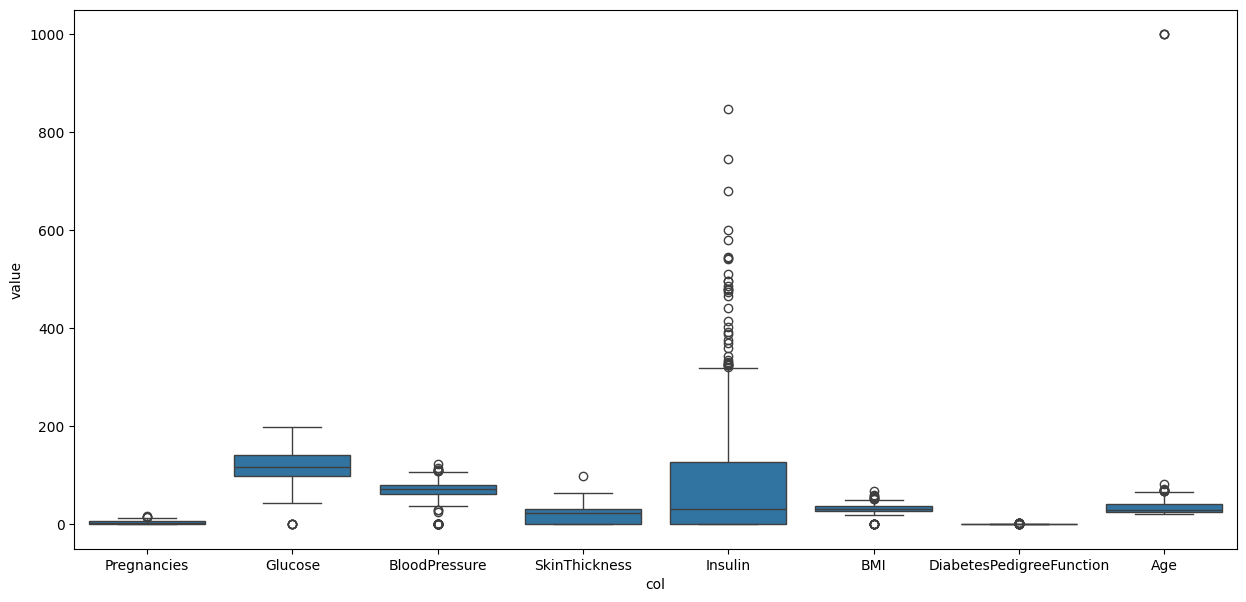

In [8]:
plt.figure(figsize = (15, 7))
sns.boxplot(x = 'col', y = 'value', data = df_v1)
plt.xticks(range(8), X.columns)
plt.show()

Age의 중앙값:  29.0


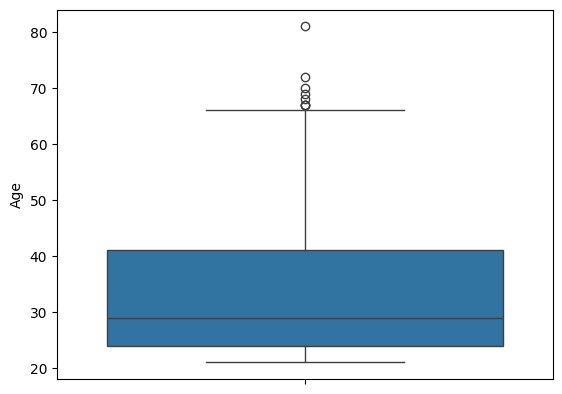

In [9]:
print('Age의 중앙값: ', df1.Age.median())
outlier_index = df1[df1['Age'] > 400].index
df1.loc[outlier_index, 'Age'] = df1.Age.median()
sns.boxplot(df1['Age'])
plt.show()

In [10]:
outlier_index = df1[df1['Glucose'] == 0].index
df1.loc[outlier_index, 'Glucose'] = df1.Glucose.median()
outlier_index = df1[df1['BloodPressure'] == 0].index
df1.loc[outlier_index, 'BloodPressure'] = df1.BloodPressure.median()

df1.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.656250,72.386719,20.536458,79.799479,31.992578,0.471876,33.191406,0.348958
std,3.369578,30.438286,12.096642,15.952218,115.244002,7.884160,0.331329,11.683509,0.476951
min,0.000000,44.000000,24.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


(3) 앞선 두 단계에서 발견한 향후 분석 시에 고려해야 할 사항을 작성하시오.

## 2. 클래스 불균형 처리
(1) 업 샘플링 과정을 설명하고 결과를 작성하시오.

소수 레이블을 가진 데이터세트를 다수 레이블을 가진 데이터세트의 수만큼 증식시켜 학습에 충분한 데이터를 확보하는 기법

In [11]:
df1['Outcome'].value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

In [12]:
X = df1.drop(['Outcome'], axis = 1)
y = df1[['Outcome']]

smote = SMOTE()
X_upsampling, y_upsampling = smote.fit_resample(X, y)

print('기존의 타깃 분포')
print(df1['Outcome'].value_counts()/len(df1))
print('-' * 10)
print('upsampling의 타깃 분포')
print(y_upsampling['Outcome'].value_counts()/len(y_upsampling))

기존의 타깃 분포
Outcome
0    0.651042
1    0.348958
Name: count, dtype: float64
----------
upsampling의 타깃 분포
Outcome
1    0.5
0    0.5
Name: count, dtype: float64


(2) 언더 샘플링 과정을 설명하고 결과를 작성하시오.

다수 클래스를 감소시켜 소수 클래스 개수를 맞추는 방식

In [13]:
tomek = TomekLinks()
X_undersampling, y_undersampling = tomek.fit_resample(X, y)

print('기존의 타깃 분포')
print(df1['Outcome'].value_counts()/len(df1))
print('-' * 10)
print('undersampling의 타깃 분포')
print(y_undersampling['Outcome'].value_counts()/len(y_undersampling))

기존의 타깃 분포
Outcome
0    0.651042
1    0.348958
Name: count, dtype: float64
----------
undersampling의 타깃 분포
Outcome
0    0.623596
1    0.376404
Name: count, dtype: float64


(3) 둘 중 하나를 선택하고 선택한 이유를 서술하시오.

데이터가 많지 않어서 over sampling을 선택함.

## 3. 모델링
(1) 최소 3개 이상의 알고리즘을 제시하고 정확도 측면의 모델 1개와 속도 측면의 모델 1개를 선정하시오.

In [14]:
log = LogisticRegression()
xgb = XGBClassifier(random_state = 526)
svm_clf = svm.SVC(kernel = 'linear')

(2) 모델을 비교하고 결과를 설명하시오.

In [17]:
smote = SMOTE(random_state = 526)

kfold = KFold()
def model_result(model):
    pred_li = []
    for train_index, test_index in kfold.split(X):
        X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
        y_train, y_test = y.iloc[train_index, :], y.iloc[test_index, :]

        X_train_resmaple, y_train_resample = smote.fit_resample(X_train, y_train)

        start = time.time()
        model.fit(X_train_resmaple, y_train_resample)
        end = time.time()

        pred = model.predict(X_test)
        pred_li.append(accuracy_score(pred, y_test['Outcome']))
    
    print(f'{end - start:.5f} sec')
    print(np.mean(pred_li))

In [18]:
model_result(log)

0.02516 sec
0.7384262796027501


In [19]:
model_result(xgb)

0.07734 sec
0.7409133350309821


In [20]:
model_result(svm_clf)

2.04394 sec
0.7410067057125881


(3) 속도 개선을 위한 차원축소 방법을 설명하고 수행하시오. 그리고 예측 성능과 속도를 비교하고 결과를 작성하시오.

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.3, random_state = 526)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
pca = PCA(n_components = 8)
X_train_pca = pca.fit(X_train_s)

print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_[:5].sum())

[0.26778233 0.22154731 0.1220605  0.10922749 0.10164174 0.07305191
 0.05386352 0.0508252 ]
0.8222593671110914


In [23]:
def pca_model_result(model):
    pred_li = []
    for train_index, test_index in kfold.split(X):
        X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
        y_train, y_test = y.iloc[train_index, :], y.iloc[test_index, :]

        X_train_resample, y_train_resample = smote.fit_resample(X_train, y_train)

        X_train_res_s = scaler.fit_transform(X_train_resample)
        X_test_s = scaler.transform(X_test)

        pca = PCA(n_components = 5)
        X_train_pca = pca.fit_transform(X_train_res_s)
        X_test_pca = pca.transform(X_test_s)

        start = time.time()
        model.fit(X_train_pca, y_train_resample)
        end = time.time()

        pred = model.predict(X_test_pca)
        pred_li.append(accuracy_score(pred, y_test['Outcome']))
    
    print(f'{end - start:.5f} sec')
    print(np.mean([pred_li]))

In [24]:
pca_model_result(log)

0.00376 sec
0.738349885408709


In [25]:
pca_model_result(xgb)

0.07106 sec
0.7240217299040829


In [26]:
pca_model_result(svm_clf)

0.02068 sec
0.7344283167812579
